In [3]:
import nltk 
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
import pandas as pd
import chardet
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

import random
import numpy as np
import torch

import openai
import tiktoken
from bertopic.representation import OpenAI

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

### Read json file into DataFrame


In [4]:
import pandas as pd
import json
file_path = r"C:\\Users\\Liu Shi Peng\\Documents\\chat_messages_202408081004.json"

with open(file_path, "rb") as f:
    json_file = json.load(f)

In [5]:
df = pd.DataFrame(list(json_file.values())[0])
docs = df['user_query'].tolist()
#print(sum(1 for i in docs if i == "yes")) - 455 messages only a single word of "yes"
#data['user_query'].groupby().head()
# x = df.groupby('user_query').count().reset_index() #.sort_values(ascending=False)
# x.sort_values(by=['message_id'], ascending = False).head(20)
len(docs)

200000

In [6]:
# slice only 5000 messages for initial modelling demo
docs = docs[:10000]

t = df.head(200000)
t['message_length'] = t['user_query'].apply(len)

bins = [0, 10, 20, 30, 40, 50, 100, 200, 500, 1000, 5000, 10000]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000', '1001-5000', '5001-10000']
t['length_bin'] = pd.cut(t['message_length'], bins=bins, labels=labels, right=False)
distribution_table = t['length_bin'].value_counts().sort_index()

#print(t)
print(distribution_table)

length_bin
0-10          11083
11-20         14286
21-30         24228
31-40         28006
41-50         24408
51-100        61501
101-200       19048
201-500       13323
501-1000       2510
1001-5000      1366
5001-10000      113
Name: count, dtype: int64


### Train the model 

In [8]:
# sentence transformers
embedding_model = SentenceTransformer('all-MiniLM-L6-v2') #'intfloat/multilingual-e5-large-instruct', 'all-MiniLM-L6-v2', 'multilingual-e5-base'
embeddings = embedding_model.encode(docs, show_progress_bar=True)
# The SentenceTransformers library focuses on generating contextual embeddings that capture the semantic meaning of sentences. 
# It does not perform tasks like stemming, lemmatization, or manual stop word removal as these are not necessary for the model's purpose.
# For better results, you might want to perform some preprocessing on your text before generating embeddings. This can include:
# Removing or replacing URLs, special characters, and excessive whitespace.
# Handling any specific text issues relevant to your data.

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
embeddings = np.load("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_100k_miniLM_0808.npy")
embeddings.shape

(100000, 384)

In [8]:
hdbscan_model = HDBSCAN(min_cluster_size=50, min_samples = 10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdb_labels = hdbscan_model.fit_predict(embeddings)

In [9]:
# #np.unique(cluster_labels)
# indices = np.where(cluster_labels == 1)
# print(type(indices))

In [10]:
import umap.umap_ as umap
import numpy as np
umap_model = umap.UMAP(n_neighbors=10, n_components=2, metric='euclidean')
umap_embeddings = umap_model.fit_transform(embeddings)
print(umap_embeddings[:5])

[[ 9.124678  -1.1497719]
 [11.043623   5.56158  ]
 [ 6.5049376 -1.9209146]
 [ 6.9381557  4.6291122]
 [11.007107   5.480948 ]]


In [72]:
# k -means 
from sklearn.cluster import KMeans

# Create and fit KMeans
kmeans = KMeans(n_clusters=10, n_init = 10)  # Choose an appropriate number of clusters
kmeans_labels = kmeans.fit_predict(umap_embeddings)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
sample_silhouette_values = silhouette_samples(umap_embeddings[,0], kmeans_labels)

In [ ]:
# pca_model = PCA(n_components=2)
# pca_embeddings = pca_model.fit_transform(embeddings)

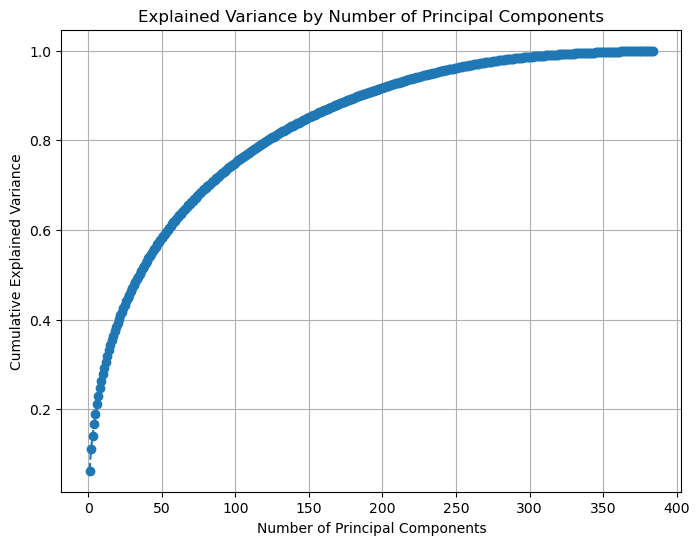

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(embeddings)
explained_variance = pca.explained_variance_ratio_

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

In [15]:
#PCA 
# from sklearn.decomposition import PCA

# # Reduce dimensionality to 2D using PCA
# pca_model = PCA(n_components=2)
# pca_embeddings = pca_model.fit_transform(embeddings)
# df_pca = pd.DataFrame(pca_embeddings, columns = ['principal_component_1','principal_component_2'])
# df_pca.head()
# plt.scatter(df_pca['principal_component_1'],df_pca['principal_component_2'], color = "#C00000")
# plt.xlabel('principal_component_1')
# plt.ylabel('principal_component_2')
# plt.title('PCA decomposition')
# print(pca_model.explained_variance_ratio_)
# # Re-run clustering on PCA-reduced embeddings
# # cluster_labels = cluster.fit_predict(pca_embeddings)

# pca_3 = PCA(n_components = 3).fit(embeddings)
# X_t = pca_3.transform(embeddings)
# df_pca_3 = pd.DataFrame(X_t,columns = ['principal_component_1','principal_component_2','principal_component_3'])
# print(pca_3.explained_variance_ratio_)
# import plotly.express as px
# fig = px.scatter_3d(df_pca_3, x = 'principal_component_1', y = 'principal_component_2', z = 'principal_component_3').update_traces(marker = dict(color = "#C00000"))
# fig.show()

# pca_10 = PCA(n_components = 50).fit(embeddings)
# print(pca_10.explained_variance_ratio_)

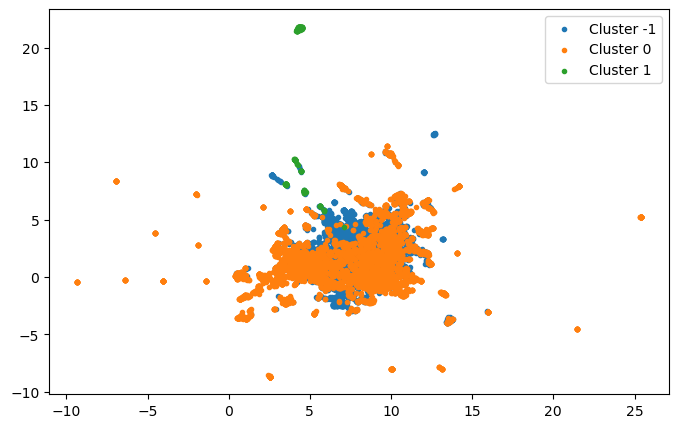

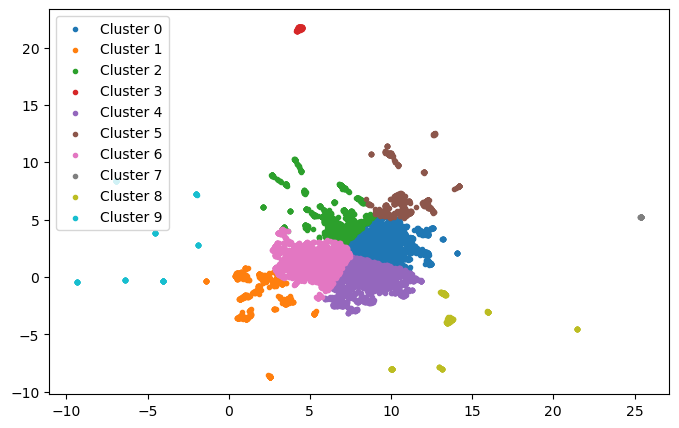

In [76]:
import matplotlib.pyplot as plt

# Define a function to visualize the clusters
def plot_clusters(embeddings, labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(8, 5))
    for label in unique_labels:
        indices = np.where(labels == label)
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=f'Cluster {label}', marker = ".")
        
    # plt.xlim(0, 15)
    # plt.ylim(-5, 15)
    plt.legend()
    plt.show()

# Plot the clusters
plot_clusters(umap_embeddings, hdb_labels)
plot_clusters(umap_embeddings, kmeans_labels)

In [139]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# umap_model = UMAP(n_neighbors=200) 
umap_embeddings = umap_model.fit_transform(embeddings)

import matplotlib.pyplot as plt
import plotly.express as px
# umap_embeddings.shape
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2', 'UMAP3'])

# Plot the UMAP embeddings with cluster labels
fig = px.scatter_3d(umap_df, x='UMAP1', y='UMAP2', z='UMAP3', opacity=0.7, size_max=8)

fig.show()

ValueError: Shape of passed values is (10000, 5), indices imply (10000, 3)

In [ ]:
#topic_model.get_document_info(docs).to_csv("C:\\Users\\Liu Shi Peng\\Documents\\topic_sample_multilingual_e5_hdb_min_30.csv", index=False, escapechar='\\')
#doc_info[doc_info["Topic"]==2]["Document"].unique()
# doc_topic = topic_model.get_document_info(docs)
# doc_topic[doc_topic['Topic']==1].drop(['Topic', 'Representative_Docs', 'Representative_document', 'Representation', 'Name'], axis=1)

In [ ]:
# topic_model.visualize_barchart(width=280, height=330, top_n_topics = 10, n_words = 15)

In [ ]:
#topic_model.visualize_topics()
# topic_model.visualize_hierarchical_documents(docs,hierarchical_topics, width=280, height=330, )#visualize_hierarchy()
print(tree)

In [ ]:
topic_model.get_topic(1, full=True)

In [ ]:
# #sub-model
# from sentence_transformers import SentenceTransformer
# embedding_model = SentenceTransformer("BAAI/bge-base-en-v1.5")

In [ ]:
# from hdbscan import HDBSCAN
# hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# topic_model = BERTopic(hdbscan_model=hdbscan_model)

# from sklearn.cluster import KMeans
# cluster_model = KMeans(n_clusters=50)
# topic_model = BERTopic(hdbscan_model=cluster_model)

# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)